In [1]:
# 设置绘图
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
#设置字体为SimHei显示中文
plt.rcParams['font.sans-serif'] = 'SimHei'
#设置正常显示字符
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
import xgboost
import math

np.random.seed(0)


In [2]:
from keras.models import Sequential  # 采用贯序模型
from keras.layers import Input, Dense, Dropout, Activation,LSTM
from keras.models import Model
from keras.optimizers import SGD
import numpy as np

In [3]:
df=pd.read_csv('T_30min with indicators.csv',index_col=0)
df.dropna(inplace=True)
df

df.insert(0,'rr',df['close_30min']/df['open_30min']-1)
df

,rr,open_30min,high_30min,low_30min,close_30min,volume_30min,MACD_12_26_30min,MACD_24_52_30min,RSI_14_30min,RSI_28_30min,...,CCI_28_5min,MFI_14_5min,MFI_20_5min,MFI_28_5min,AR_10_5min,BR_10_5min,AR_20_5min,BR_20_5min,AR_26_5min,BR_26_5min
2018/12/5 10:15,-0.000051,97.330,97.355,97.270,97.325,6163,0.095268,0.086420,76.154149,66.967819,...,66.519337,42.975289,47.466434,39.133915,73.913043,70.212766,110.389610,194.202899,90.909091,151.000000
2018/12/5 10:45,-0.000051,97.325,97.345,97.295,97.320,2858,0.105405,0.095897,75.643044,66.740675,...,44.962498,32.421742,45.310396,44.576565,84.375000,90.322581,102.597403,181.428571,108.791209,185.185185
2018/12/5 11:15,0.000000,97.320,97.355,97.295,97.320,2179,0.114574,0.105283,75.643044,66.740675,...,34.367080,66.403160,36.336553,45.447290,117.391304,121.739130,111.111111,116.981132,108.988764,178.048780
2018/12/5 13:15,-0.000103,97.320,97.330,97.280,97.310,2418,0.122234,0.114218,74.483530,66.257296,...,-60.527454,53.042032,56.076101,33.969069,136.363636,136.363636,118.181818,130.952381,113.636364,111.940299
2018/12/5 13:45,-0.000308,97.310,97.310,97.230,97.280,4172,0.127790,0.122286,70.968888,64.797242,...,-122.022621,30.130904,40.149974,42.214855,65.625000,65.625000,82.456140,81.034483,84.507042,91.304348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020/12/17 13:30,0.000206,97.245,97.280,97.220,97.265,4083,-0.009183,-0.016558,42.354323,45.410411,...,-43.927568,42.711543,30.602935,39.539902,123.809524,123.809524,61.428571,56.944444,79.761905,78.823529
2020/12/17 14:00,0.000000,97.260,97.290,97.255,97.260,3955,-0.012000,-0.018119,41.918905,45.190073,...,-33.205985,36.489343,37.241049,27.206273,192.857143,173.333333,104.255319,104.255319,72.500000,68.292683
2020/12/17 14:30,-0.000360,97.260,97.280,97.215,97.225,4976,-0.015243,-0.020067,38.903922,43.652499,...,-189.247312,28.732549,34.617901,29.758558,78.571429,75.862069,108.510638,102.040816,96.923077,92.537313
2020/12/17 15:00,-0.000154,97.225,97.250,97.210,97.210,3783,-0.018786,-0.022355,37.653970,43.002217,...,-148.346128,26.445989,29.630146,36.590212,100.000000,82.142857,113.953488,102.173913,117.241379,108.196721


## 数据降维


In [4]:


from sklearn.decomposition import PCA

pca = PCA()   #保留所有成分
pca.fit(df)
pca.components_ #返回模型的各个特征向量
pca.explained_variance_ratio_ #返回各个成分各自的方差百分比(也称贡献率）

# 通过上面的结果选择几个贡献率
pca = PCA(3)  #选取累计贡献率大于80%的主成分（3个主成分）
pca.fit(df)
df_dim = pca.transform(df)   #降低维度

df_dim=pd.DataFrame(df_dim)
df_dim;

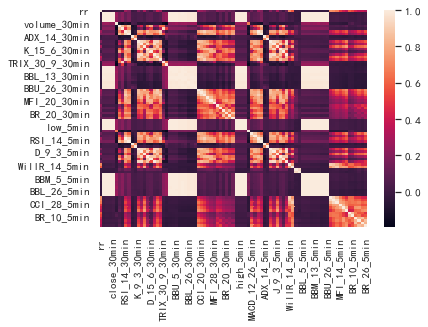

In [5]:
sns.heatmap(df.corr())
plt.savefig('corr.svg')
plt.show()

In [6]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    return dataset
df=correlation(df,0.8)
df

,rr,open_30min,volume_30min,MACD_12_26_30min,RSI_14_30min,ADX_14_30min,ADX_28_30min,K_9_3_30min,TRIX_30_9_30min,TRIX_60_15_30min,...,BR_20_30min,volume_5min,MACD_12_26_5min,WillR_14_5min,TRIX_30_9_5min,MFI_14_5min,MFI_28_5min,AR_10_5min,AR_20_5min,BR_26_5min
2018/12/5 10:15,-0.000051,97.330,6163,0.095268,76.154149,34.582740,17.412006,78.371526,0.003048,0.003868,...,196.178344,458.0,0.063166,-20.895522,1.465998,42.975289,39.133915,73.913043,110.389610,151.000000
2018/12/5 10:45,-0.000051,97.325,2858,0.105405,75.643044,36.335907,18.241438,79.655091,0.003401,0.003860,...,271.304348,373.0,0.053877,-52.380952,1.041360,32.421742,44.576565,84.375000,102.597403,185.185185
2018/12/5 11:15,0.000000,97.320,2179,0.114574,75.643044,38.003958,19.056562,79.852365,0.003791,0.003861,...,252.500000,317.0,0.039195,-53.846154,0.744857,66.403160,45.447290,117.391304,111.111111,178.048780
2018/12/5 13:15,-0.000103,97.320,2418,0.122234,74.483530,39.305217,19.786591,78.568244,0.004213,0.003871,...,231.250000,323.0,0.022795,-60.000000,0.505980,53.042032,33.969069,136.363636,118.181818,111.940299
2018/12/5 13:45,-0.000308,97.310,4172,0.127790,70.968888,39.706727,20.306258,75.045496,0.004658,0.003890,...,212.500000,321.0,0.008951,-56.521739,0.363591,30.130904,42.214855,65.625000,82.456140,91.304348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020/12/17 13:30,0.000206,97.245,4083,-0.009183,42.354323,14.599749,9.135214,27.022200,-0.001338,-0.000331,...,71.794872,416.0,-0.021691,-35.714286,-0.001175,42.711543,39.539902,123.809524,61.428571,78.823529
2020/12/17 14:00,0.000000,97.260,3955,-0.012000,41.918905,14.452013,8.970579,24.518865,-0.001344,-0.000342,...,72.549020,838.0,-0.015611,-42.857143,-0.001507,36.489343,27.206273,192.857143,104.255319,68.292683
2020/12/17 14:30,-0.000360,97.260,4976,-0.015243,38.903922,14.848171,8.951933,17.933212,-0.001358,-0.000354,...,67.295597,970.0,-0.012716,-86.666667,-0.001645,28.732549,29.758558,78.571429,108.510638,92.537313
2020/12/17 15:00,-0.000154,97.225,3783,-0.018786,37.653970,15.280952,8.951276,11.955475,-0.001382,-0.000367,...,69.281046,910.0,-0.014616,-100.000000,-0.001730,26.445989,36.590212,100.000000,113.953488,108.196721


## 生成数据集

In [7]:
dataset=df


def create_dataset(dataset:np.ndarray, look_back:int):  # 后一个数据和前look_back个数据有关系
    assert not (isinstance(dataset,np.ndarray) and isinstance(dataset,pd.core.frame.DataFrame)) ,'输入数据格式不符合要求，使用pandas或numpy'
    dataset=np.array(dataset)

    dataX, dataY = [],[]
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)  #
        dataY.append(dataset[:,0][i + look_back]) #此处Y要第一列（收益率） 
        
    dataX,dataY=np.array(dataX),np.array(dataY)
    dataX,dataY=np.reshape(dataX,(dataX.shape[0],-1)),np.reshape(dataY,(-1,1))# 转变为二维数据
    
    # 进行数据归一化
    from sklearn.preprocessing import MinMaxScaler
    
    scalerX = MinMaxScaler(feature_range=(0, 1))  # 归一化0-1
    scalerX.fit(dataX)
    dataX=scalerX.transform(dataX)

    scalerY = MinMaxScaler(feature_range=(0, 1))  # 归一化0-1
    scalerY.fit(dataY)
    dataY=scalerY.transform(dataY)
    
    return np.array(dataX), np.array(dataY),scalerX,scalerY  # 生成输入数据和输出数据

In [8]:
totX, totY, scalerX, scalerY = create_dataset(np.array(dataset), look_back=10)  # 训练输入输出

def split_dataset(dataset):
    dataset=np.array(dataset)
    train_size = int(len(dataset) * 0.67)  # %67的训练集，剩下测试集
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]  # 训练集和测试集    
    return train,test

trainX,testX=split_dataset(totX)
trainY,testY=split_dataset(totY)
print(trainX.shape)

(2976, 240)


In [9]:
tBatchSize = 128
'''第一步：选择模型'''
model = Sequential()  # 采用贯序模型

'''第二步：构建网络层'''
'''构建网络只是构建了一个网络结构，并定义网络的参数，此时还没有输入的数据集'''
# 构建的第一个层作为输入层
# Dense 这是第一个隐藏层，并附带定义了输入层，该隐含层有500个神经元。输入则是 784个节点
model.add(Dense(50, input_shape=(trainX.shape[1],)))  # 输入层，28*28=784 输入层将二维矩阵换成了一维向量输入
model.add(Activation('relu'))  # 激活函数是relu
model.add(Dropout(0.5))  # 采用50%的dropout  随机取一半进行训练

# 构建的第2个层作为隐藏层2， （如果加上输入层，实际上是第三层）
model.add(Dense(50))  # 隐藏层节点50个
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(50))  # 隐藏层3，节点50个
model.add(Activation('relu'))
# model.add(Dropout(0.5))

# 构建的第3个层作为输出层
model.add(Dense(1))  # 

'''第三步：网络优化和编译'''
#   lr：大于0的浮点数，学习率
#   momentum：大于0的浮点数，动量参数
#   decay：大于0的浮点数，每次更新后的学习率衰减值
#   nesterov：布尔值，确定是否使用Nesterov动量
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  # 优化函数，设定学习率（lr）等参数
model.compile(loss='mean_squared_error', optimizer=sgd)  #均方误差作为损失函数，优化器为sgd

In [10]:
model.fit(trainX, trainY, batch_size=tBatchSize, epochs=50, shuffle=True, verbose=1, validation_split=0.3)
print('模型训练完成')
# model.evaluate(testX, testY, batch_size=200, verbose=0)


Epoch 1/50
17/17 [==============================] - 0s 8ms/step - loss: 0.1258 - val_loss: 0.0116
Epoch 2/50
17/17 [==============================] - 0s 3ms/step - loss: 0.0106 - val_loss: 0.0067
Epoch 3/50
17/17 [==============================] - 0s 3ms/step - loss: 0.0068 - val_loss: 0.0065
Epoch 4/50
17/17 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0064
Epoch 5/50
17/17 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0064
Epoch 6/50
17/17 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0064
Epoch 7/50
17/17 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0064
Epoch 8/50
17/17 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0064
Epoch 9/50
17/17 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0064
Epoch 10/50
17/17 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0064
Epoch 11/50
17/17 [

In [11]:
def result_plot(result):
    result_raw=scalerY.inverse_transform(result)
    testY_raw=scalerY.inverse_transform(testY)

    print('预测与实际的收益率情况')
    sns.distplot(pd.DataFrame(result_raw[:,0]))
    sns.distplot(pd.DataFrame(testY_raw[:,0]))
    plt.legend(['预测','实际'])
    plt.show()
    
    result_df=pd.DataFrame({'pred':result_raw[:,0]})
    result_df['real']=testY_raw[:,0]


    result_df['buy']=result_df['pred']>0 #只做多
    result_df['buy_and_sell']=result_df['pred'].apply(lambda x:1 if x>0 else -1 ) # 加做空

    result_df['real_return']=(1+result_df['real']).cumprod()
    result_df['stg_buy']=((result_df['real']*result_df['buy'])+1).cumprod()
    result_df['stg_buy_and_sell']=((result_df['real']*result_df['buy_and_sell'])+1).cumprod()
    return result_df

In [12]:
# model.save('一个预测集表现特别好的model.h5')

预测与实际的收益率情况


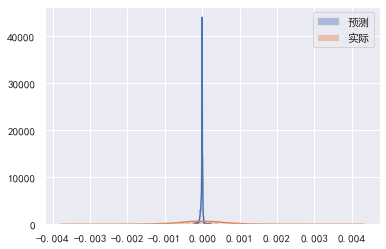

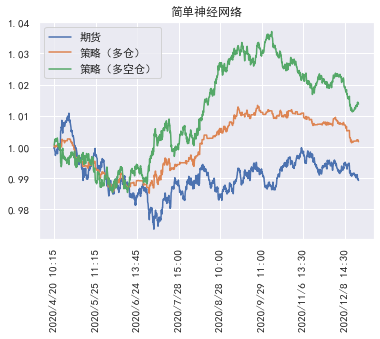

,real,buy_rr,buy_sell_rr
信息比率,-0.157281,0.045271,0.209646
累计收益率,0.989163,1.001623,1.013721
每日收益率,-0.000007,0.000001,0.000010
最大每日收益,0.003900,0.002586,0.003362
最大每日损失,-0.003362,-0.002416,-0.003900
上涨天数,689.000000,236.000000,727.000000
下跌天数,726.000000,235.000000,688.000000
不变天数,51.000000,995.000000,51.000000
胜率,0.486926,0.501062,0.513781
上涨时平均每日收益率,0.000567,0.000570,0.000554


In [14]:
test_pred= model.predict(testX, batch_size=tBatchSize, verbose=0)
result_df=result_plot(test_pred)
result_df.index=df.index[-len(result_df):]

plt.show()
result_df[['real_return','stg_buy','stg_buy_and_sell']].plot(title='简单神经网络')
plt.legend(['期货','策略（多仓）','策略（多空仓）'])
plt.xticks(rotation=90)
plt.show()
from source.Ratio import ratio

result_df['buy_rr']=result_df['real']*result_df['buy']
result_df['buy_sell_rr']=result_df['real']*result_df['buy_and_sell']
ratio().cal_ratio(pd.DataFrame(result_df[['real','buy_rr','buy_sell_rr']]),day=False)


## LSTM

In [15]:
# 调整数据的输入格式，24维*10天
trainX_LSTM=np.reshape(trainX,(trainX.shape[0],24,-1)) 
testX_LSTM=np.reshape(testX,(testX.shape[0],24,-1))

trainX.shape

(2976, 240)

In [16]:
model = Sequential()

model.add(LSTM(11, input_shape=(24,10)))  # 隐层11个神经元 ,输入数据格式为24维*10天
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')  # 评价函数mse，优化器adam
model.fit(trainX_LSTM, trainY, epochs=50, batch_size=100, verbose=1)  # 100次迭代


Epoch 1/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0756
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0097
Epoch 3/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0085
Epoch 4/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0079
Epoch 5/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0074
Epoch 6/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0069
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0065
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0063
Epoch 9/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0060
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0059
Epoch 11/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0058
Epoch 12/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0057
Epoch 13/50
30/30 [==============================

In [17]:
trainPredict = model.predict(trainX_LSTM)
testPredict = model.predict(testX_LSTM)
# 数据反归一化

print('test:',testPredict)
print(trainPredict.shape)
print(trainY.shape)
trainPredict=trainPredict.reshape(trainPredict.shape[0],-1)
trainY=trainY.reshape(trainY.shape[0],1)
testPredict=testPredict.reshape(testPredict.shape[0],-1)
testY=testY.reshape(testY.shape[0],1)


test: [[0.47800693]
 [0.46992588]
 [0.46360642]
 ...
 [0.46927553]
 [0.46504888]
 [0.4665818 ]]
(2976, 1)
(2976, 1)


In [18]:
from sklearn.metrics import mean_squared_error

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.5f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.5f RMSE' % (testScore))




Train Score: 0.07456 RMSE
Test Score: 0.08578 RMSE


预测与实际的收益率情况


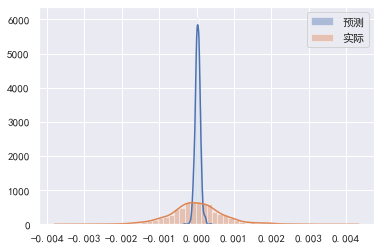

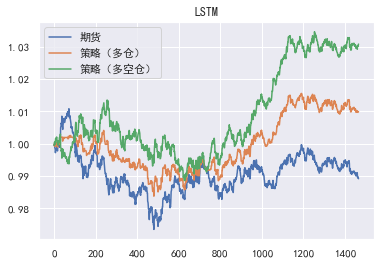

In [19]:

# 根据模型获取预测结果  为了节约计算内存，也是分组（batch）load到内存中的，
result= model.predict(testX_LSTM, batch_size=tBatchSize, verbose=0)
result_df=result_plot(result)

plt.show()
result_df[['real_return','stg_buy','stg_buy_and_sell']].plot(title='LSTM')
plt.legend(['期货','策略（多仓）','策略（多空仓）'])
plt.show()

In [20]:
from source.Ratio import ratio

result_df['buy_rr']=result_df['real']*result_df['buy']
result_df['buy_sell_rr']=result_df['real']*result_df['buy_and_sell']
ratio().cal_ratio(pd.DataFrame(result_df[['real','buy_rr','buy_sell_rr']]),day=False)


,real,buy_rr,buy_sell_rr
信息比率,-0.157281,0.187155,0.459295
累计收益率,0.989163,1.009886,1.030767
每日收益率,-0.000007,0.000007,0.000021
最大每日收益,0.003900,0.002443,0.002867
最大每日损失,-0.003362,-0.003362,-0.003900
上涨天数,689.000000,484.000000,731.000000
下跌天数,726.000000,479.000000,684.000000
不变天数,51.000000,503.000000,51.000000
胜率,0.486926,0.502596,0.516608
上涨时平均每日收益率,0.000567,0.000556,0.000563


## xgboost


In [33]:

import xgboost as xgb

look_back=20
trainX=np.reshape(trainX,(trainX.shape[0],-1))
testX=np.reshape(testX,(testX.shape[0],-1))

#     train_x,train_y,test_x,test_y,scaler=data_processing_xgb(price_series,look_back)
dtrain = xgb.DMatrix(trainX, label = trainY)
dtest = xgb.DMatrix(testX)
# 参数设置
params={
    'booster':'gbtree',
    'objective':'reg:squarederror',
    'eval_metric': 'auc',
    'max_depth':4,
    'lambda':10,
    'subsample':0.75,
    'colsample_bytree':0.75,
    'min_child_weight':2,
    'eta': 0.025,
#     'seed':0,#随机数的种子
    # 'nthread':8, #XGBoost运行时的线程数。缺省值是当前系统可以获得的最大线程数
    }

watchlist = [(dtrain,'train')]
# 进行训练
model=xgb.train(params,dtrain,num_boost_round=1000,evals=watchlist,verbose_eval=1000)



[0]	train-auc:0.51339
[999]	train-auc:0.57547


In [34]:
# 预测
test_predict=model.predict(dtest)
test_predict=np.reshape(test_predict,(-1,1))
test_predict

array([[0.5328393 ],
       [0.50650656],
       [0.47033107],
       ...,
       [0.49523234],
       [0.47389224],
       [0.549123  ]], dtype=float32)

预测与实际的收益率情况


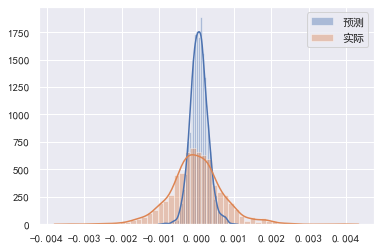

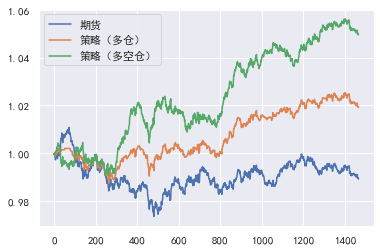

In [35]:
result_df=result_plot(test_predict)
plt.show()
result_df[['real_return','stg_buy','stg_buy_and_sell']].plot()
plt.legend(['期货','策略（多仓）','策略（多空仓）'])
plt.show()

In [36]:
from source.Ratio import ratio
result_df['buy_rr']=result_df['real']*result_df['buy']
result_df['buy_sell_rr']=result_df['real']*result_df['buy_and_sell']
ratio().cal_ratio(pd.DataFrame(result_df[['real','buy_rr','buy_sell_rr']]),day=False)

,real,buy_rr,buy_sell_rr
信息比率,-0.157281,0.364100,0.730867
累计收益率,0.989163,1.019086,1.049608
每日收益率,-0.000007,0.000013,0.000033
最大每日收益,0.003900,0.002599,0.002702
最大每日损失,-0.003362,-0.003362,-0.003900
上涨天数,689.000000,436.000000,725.000000
下跌天数,726.000000,437.000000,690.000000
不变天数,51.000000,593.000000,51.000000
胜率,0.486926,0.499427,0.512367
上涨时平均每日收益率,0.000567,0.000580,0.000580
